### Importing useful libs

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd


### loading the data

In [3]:
dataset = pd.read_csv("ames.csv")

### sampling the data

In [4]:
dataset.sample(2)

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YearSold,SaleType,SaleCondition,SalePrice
1473,Two_Story_1946_and_Newer,Residential_Low_Density,65.0,8450.0,Pave,No_Alley_Access,Regular,Lvl,AllPub,Inside,...,0.0,No_Pool,No_Fence,NaN,0.0,2,2008,WD,Normal,208500
409,Two_Story_PUD_1946_and_Newer,Residential_Low_Density,24.0,2308.0,Pave,No_Alley_Access,Regular,Lvl,AllPub,FR2,...,0.0,No_Pool,No_Fence,NaN,0.0,9,2009,WD,Normal,146000


## K-means Cluster (Plus) end to end class from scratch
### The difference between plus and normal k-means is that, 
### - we pick the initial centroids as completely random in normal verson.
### - but in plus, we choose the first cluster randomly, then for the next cluster, we calculate distance from each cluster to each point, and take the minimum distance out of all clusters
### - after that we, convert these distances into probabilites, by dividing the distances by their total sum
### - giving each points their respective probabilies, we draw a random sample out of all data points for our next cluster


In [ ]:
class KMeansPlus:
    def __init__(self, k, n_init = 10, iters = 100): 
        self._k = k #no. of clusters
        self._n_init = n_init # no of times the centroid is re initialized
        self._iters = iters # no. of iterations to find best centriod
    
    def fit_predict(self, data):

        if isinstance(data,pd.DataFrame): # chcking if data is a DataFrame
            if not all(pd.api.types.is_numeric_dtype(dtype) for dtype in data.dtypes): # checking for numeric cols
                raise ValueError("All columns should be numeric") 
            
            np_data = data.to_numpy() # converting to numpy array

        elif isinstance(data,pd.Series):
            if not pd.api.types.is_numeric_dtype(data): # same , checking if seris is numeric
                raise ValueError("Values should be numeric")
            
            np_data = data.to_numpy().reshape(-1,1) # reshaping for better interpretation

        else:
            raise TypeError("Data should be either a pandas dataframe or series")  #only accepting df or series      

        def manhattan_dist(sample,data,transpose = True):
            dist_array = np.sum(abs(sample - data),axis=1) # absolute ( x1 - x2) + absolute (y1 - y2) + absolute (z1 - z2) + etc etc
            if (transpose): # giving the flexibilty for transposing (needed for future calculation)
                return dist_array.reshape(-1,1)
            else:
                return dist_array

        inertia_container = [] # will keep record of variance of each centroid set
        clusters_container = [] # each centriod set of all the n_init
        points_container = [] # each point set of all the n_init
        labels_container = [] # each label set of all the n_init

        for _ in range(self._n_init): # running whole algo till n_init
            clusters = np.empty((self._k,np_data.shape[1])) # as k is no.clusters, and no. of columns will be the dimension, the final shape is (k,cols)

            first_sample = np_data[np.random.choice(np_data.shape[0], 1, replace=False)] #choosing the first sample randomly as per kmeans plus
            
            clusters[0] = first_sample
            
            cluster_differences = manhattan_dist(first_sample,np_data) # calculating mathattan dist from all datapoints

            for i in range(1,self._k): # now running loop for the leftover clusters , to initialize them
                closest_cluster_distance = np.min(cluster_differences,axis=1) # calculating the distance of (closest cluster of a point) -> (to that point)
                probs = closest_cluster_distance / np.nansum(closest_cluster_distance) # converting these distances into probs
                probs = np.nan_to_num(probs, nan=0.0) # making sure no prob is null
                idx = np.random.choice(np_data.shape[0], p=probs.ravel()) # choosing a random sample, based on the given probability of each data point

                clusters[i] = np_data[idx] # assigning that random sameple as the new cluster

                cluster_differences = np.concatenate((cluster_differences,manhattan_dist(clusters[i],np_data)),axis=1) # calculating the manhattan dist from each data point to each cluster

            prev_min_cluster = np.empty((np_data.shape[0],)) # keeping record of previous labels (clusters) of each data point
            for _ in range(self._iters):
                
                cluster_distance = np.empty((np_data.shape[0],self._k)) # making an empty array, (each data point, each cluster)
                for j in range(self._k):
                    cluster_distance[:,j] = manhattan_dist(clusters[j],np_data,transpose=False) # calculating distance from each data point to each cluster
        

                min_clusters = np.argmin(cluster_distance,axis=1) # choosing the cluster for each data point which has the minimum distance from them

                if np.array_equal(prev_min_cluster,min_clusters): # checking if previous iteration labels are equal to this iteration labels
                    break # if they are equal, that means the algorithm has converged
                
                for k in range(self._k):
                    idx = np.where(min_clusters == k) # getting the index of datapoints where the kth cluster is minimum
                    clusters[k] = np.nanmedian(np_data[idx], axis=0) if idx[0].size > 0 else clusters[k] # calculating the median of all those points, if no points come under centriod, new centr = prev centr

                prev_min_cluster = min_clusters # updating the prev label record

            residuals = 0 # you can also call it variance, this will tell us the performance of model
            points=[] #the data points separated by clusters
            for l in range(self._k):
               idx = np.where(min_clusters == l) # using the last iteration's minimum cluster labels for each datapoints
               points.append(np_data[idx]) #appending data points per cluster
               residuals+=np.nansum((clusters[l] - np_data[idx])**2)  # summing up the variance , or distance^2 from each datapoint to that cluster. 
            
            
            inertia_container.append(residuals) # updating 
            clusters_container.append(clusters) # updating
            points_container.append(points)      #updating
            labels_container.append(min_clusters)   #updating
            
        min_interia_idx = np.argmin(np.array(inertia_container)) #converting intertia container to numpy to find the minimum index, which will be used in other arrays
        #using the initialization which has the least intertia
        return clusters_container[min_interia_idx], points_container[min_interia_idx], labels_container[min_interia_idx],inertia_container[min_interia_idx]
        # returning the cluster data points , the actual data points separated by clusters, the cluster labels per data point, total intertia of the model

---

### Testing our model class

In [16]:
model = KMeansPlus(k = 3,n_init=10,iters=100)
centers,points,labels,intertia = model.fit_predict(dataset[["YearBuilt"]])

<Axes: xlabel='YearBuilt', ylabel='SalePrice'>

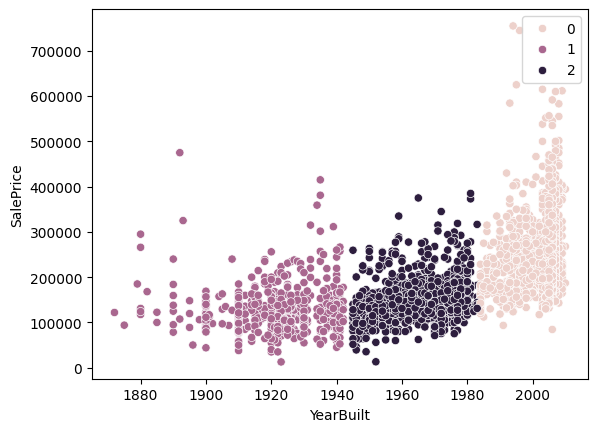

In [17]:
sns.scatterplot(data = dataset,x="YearBuilt",y="SalePrice",hue=labels)

---

### Elbow method: choosing the best K value, the K-value after which the future values of K starts smoothing out

In [18]:
intertias = []
k_values = []
for i in range(1,11):
    model = KMeansPlus(k = i,n_init=10,iters=100)
    centers,points,labels,intertia = model.fit_predict(dataset[["YearBuilt"]])
    intertias.append(intertia)
    k_values.append(i)

Text(0, 0.5, 'Inertia')

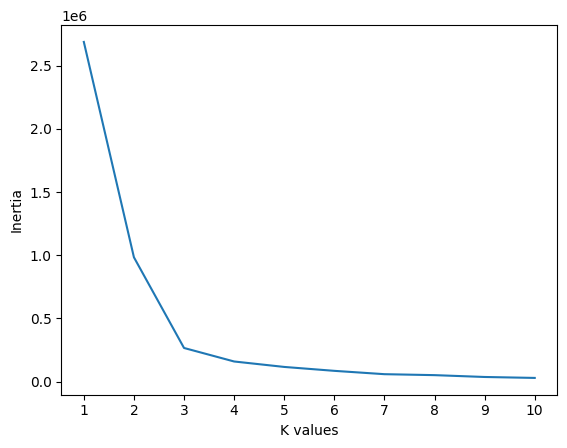

In [19]:
plt.plot(k_values,intertias)
plt.xlabel("K values")
plt.xticks(k_values)
plt.ylabel("Inertia")

### Here we can see there is an elbow like drop from 2 to 3, and after 3, the intertia smoothes out. 
# Therefore K = 3 is the best solution

---